## DeepSruv-TF demo for simulated linear and non-linear data

In [1]:
# Set environment variable
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple GPUs
# impoart tensorflow
import tensorflow as tf
print(tf.__version__)
# Allow growing memmory 
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

1.10.0


### Import DeepSurv packages

In [2]:
import sys
sys.path.append("deepsurv")
import deepsurv_tf
import deepsurv

### Import utility packages

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy
import seaborn as sns
import pandas
import h5py as h5
import lasagne

In [4]:
import sys
sys.path.append("deepsurv")
%matplotlib inline

In [5]:
epochs= 3000

def h5_to_deepsurv_ds(file_, type='train'):
    e = file_[type]['e'].value
    t = file_[type]['t'].value
    x = file_[type]['x'].value

    # Return the deep surv dataframe
    return {
        'x': x,
        'e': e,
        't': t
    }

params = deepsurv_tf.Parameters()
params.n_epochs = epochs

### Simulatd linear survival data

In [ ]:
dataset = h5.File("data/linear/linear_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')
test = h5_to_deepsurv_ds(dataset, 'test')

Training done
Best epoch 700
Best loss 3016.077


INFO:tensorflow:Restoring parameters from out/learned.model


/home/tuemura/.virtualenvs/DeepSurv-py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


model loaded
test CI: 0.771802535023349


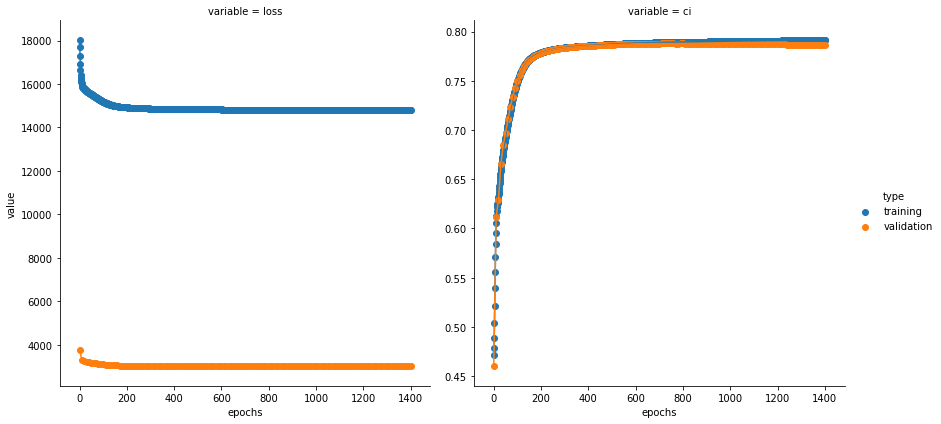

In [6]:
params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))

#### Run deepsurv-theanos

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


test CI: 0.6339719813208806


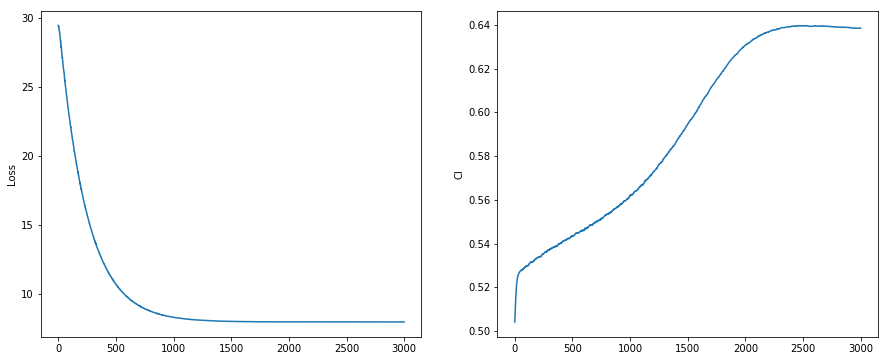

In [7]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train['x'].shape[1],
    'standardize': True
}

network = deepsurv.DeepSurv(**hyperparams)
update_fn = lasagne.updates.nesterov_momentum

log = network.train(train, valid, n_epochs=epochs, update_fn=update_fn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
ax1.plot(log["train"], label="training loss")
ax1.set_ylabel("Loss")
ax2.set_ylabel("CI")
ax2.plot(log["train_ci"], label="training ci")
print("test CI: {}".format(network.get_concordance_index(test['x'], test['t'], test['e'])))

### Simulated non-linear (Gaussian) survival data

In [8]:
dataset = h5.File("data/gaussian/gaussian_survival_data.h5", 'r')

train = h5_to_deepsurv_ds(dataset)
valid = h5_to_deepsurv_ds(dataset, 'valid')
test = h5_to_deepsurv_ds(dataset, 'test')

Training done
Best epoch 2990
Best loss 3219.6123


INFO:tensorflow:Restoring parameters from out/learned.model


/home/tuemura/.virtualenvs/DeepSurv-py3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


model loaded
test CI: 0.6393662441627752


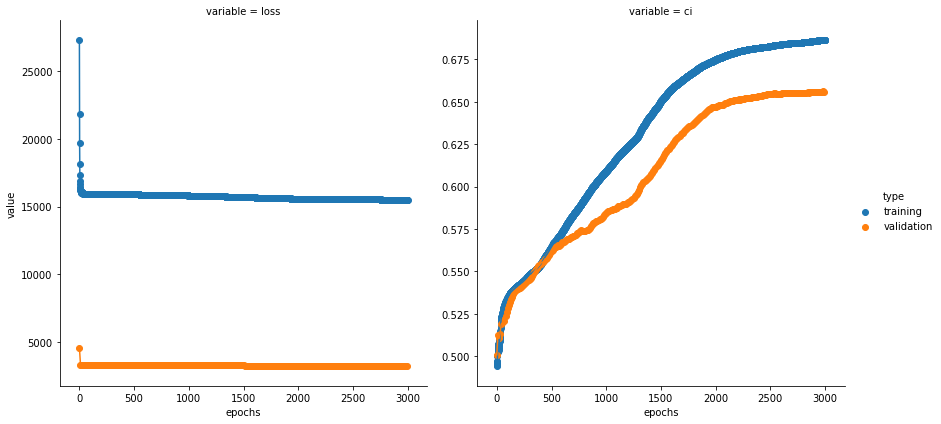

In [9]:
params.n_in = train['x'].shape[1]

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop=True)
stats = pandas.melt(stats, id_vars=["epochs", "type"])

sns.FacetGrid(data=stats, hue="type", col="variable", sharey=False, size=6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

print("test CI: {}".format(ds_tf.get_concordance_index(test['x'], test['e'], test['t'])))

#### Run deepsurv-theano

test CI: 0.516603068712475


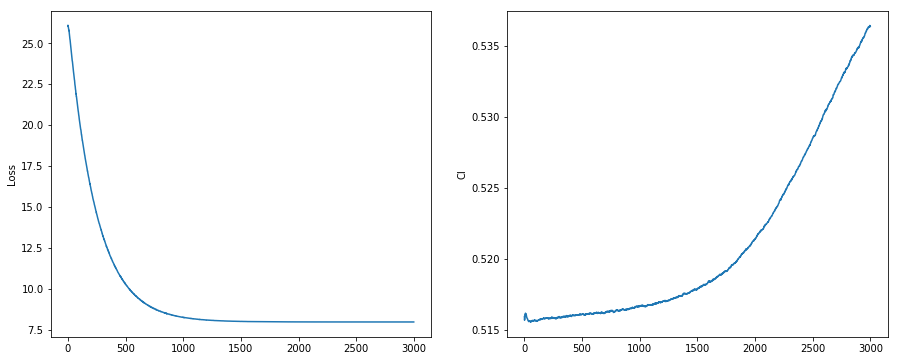

In [10]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train['x'].shape[1],
    'standardize': True
}

network = deepsurv.DeepSurv(**hyperparams)
update_fn = lasagne.updates.nesterov_momentum

log = network.train(train, valid, n_epochs=epochs, update_fn=update_fn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(log["train"], label="training loss")
ax1.set_ylabel("Loss")
ax2.set_ylabel("CI")
ax2.plot(log["train_ci"], label="training ci")
print("test CI: {}".format(network.get_concordance_index(test['x'], test['t'], test['e'])))